In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20, 16)})

In [2]:
df = pd.read_csv('../data/Modelar_UH2021.txt', sep="|", decimal = ",")

In [3]:
df.head()

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,1/6/2015 0:00:00,21972,0,C,75.0,No Rotura,NaN,0,0,5241.0,0
1,1/6/2015 0:00:00,23910,5,C,170.0,No Rotura,6.07,0,0,5241.0,3
2,1/6/2015 0:00:00,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
3,1/6/2015 0:00:00,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
4,1/6/2015 0:00:00,27144,15,E,230.0,No Rotura,NaN,0,0,4064.0,0


In [4]:
df.shape

(4045022, 11)

In [5]:
df.dtypes

fecha                 object
id                     int64
visitas                int64
categoria_uno         object
categoria_dos        float64
estado                object
precio               float64
dia_atipico            int64
campaña                int64
antiguedad           float64
unidades_vendidas      int64
dtype: object

In [6]:
df[['estado']].value_counts(sort=False)

estado   
No Rotura    3388184
Rotura        606530
Transito       50308
dtype: int64

Buscamos valores null en las columnas que forman el conjunto de datos.

In [7]:
missing_columns = df.columns[df.isna().any()].tolist()
missing_columns

['categoria_dos', 'precio', 'antiguedad']

Podemos observar que hay tres columnas con valores nulos. Ahora lo que vamos a hacer es ver con cuántos valores nulos cuenta cada una de ellas y de esta manera, decidir de qué forma tratarlos.

In [8]:
missing_data = df.isnull() # Los valores null se representan como True

for column in missing_columns:
    print(column)
    print (missing_data[column].value_counts())
    print("")

categoria_dos
False    4039178
True        5844
Name: categoria_dos, dtype: int64

precio
True     2642911
False    1402111
Name: precio, dtype: int64

antiguedad
False    3170857
True      874165
Name: antiguedad, dtype: int64



Cantidad de valores null por columna:
* `categoria_dos`: 5844
* `precio`: 1402111
* `antiguedad`: 874165

Para tratar los valores nulos de la columna `categoria_dos` vamos a reemplazarlos por el valor más frecuente de esta:

In [9]:
most_freq = df['categoria_dos'].mode().values[0]
most_freq

307.0

In [10]:
df['categoria_dos'].replace(np.nan, most_freq, inplace=True)

Para tratar los valores nulos de la columna `precio` vamos a realizar lo que se indica en las instrucciones del reto "*Cuando su valor es nulo, ha de ser completado con el precio anterior temporalmente más cercano para cada artículo.*"

In [11]:
#TODO

Para tratar los valores nulos de la columna `antiguedad` vamos a reemplazarlos por la media de esta columna:

In [12]:
mean_val = int(df['antiguedad'].mean())
mean_val

1011

In [13]:
df['antiguedad'].replace(np.nan, mean_val, inplace=True)

Vamos a cambiar los tipos de datos de las columnas para poder tratarlos en un futuro.

In [14]:
df[['categoria_uno', 'estado']] = df[['categoria_uno', 'estado']].astype(str)
df['fecha'] = pd.to_datetime(df['fecha'])

print(df.dtypes)
df.head()


fecha                datetime64[ns]
id                            int64
visitas                       int64
categoria_uno                object
categoria_dos               float64
estado                       object
precio                      float64
dia_atipico                   int64
campaña                       int64
antiguedad                  float64
unidades_vendidas             int64
dtype: object


,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,2015-01-06,21972,0,C,75.0,No Rotura,NaN,0,0,5241.0,0
1,2015-01-06,23910,5,C,170.0,No Rotura,6.07,0,0,5241.0,3
2,2015-01-06,24306,13,A,46.0,No Rotura,NaN,0,0,1011.0,0
3,2015-01-06,24306,13,A,46.0,No Rotura,NaN,0,0,1011.0,0
4,2015-01-06,27144,15,E,230.0,No Rotura,NaN,0,0,4064.0,0


Aquí podemos visualizar las ventas por meses para poder distinguir si hay una diferencia notoria de ventas entre ellos

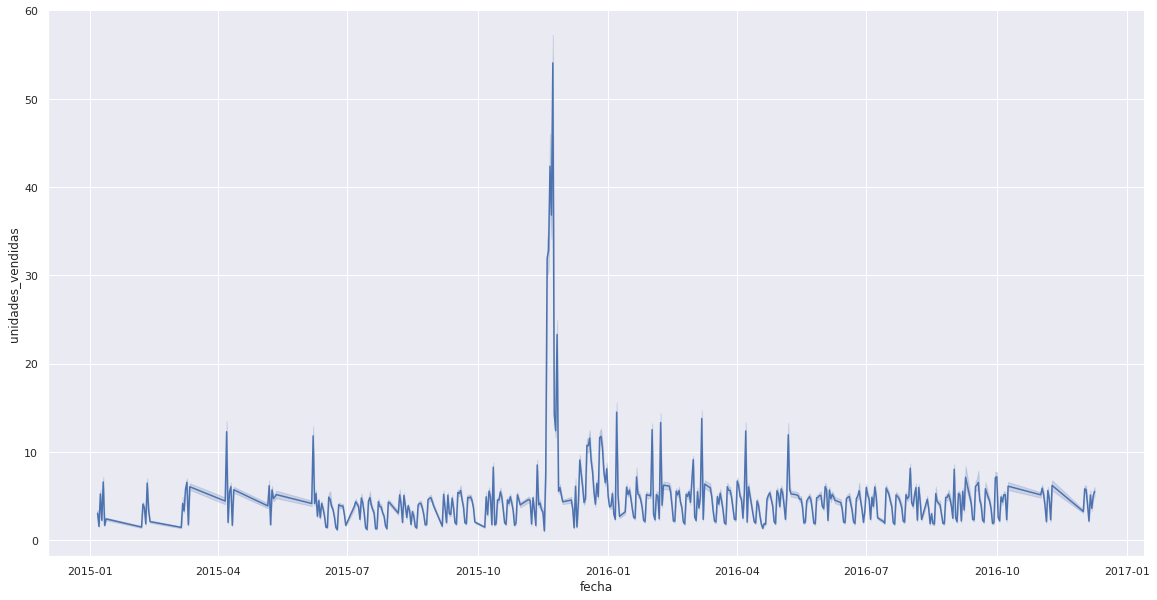

In [26]:
sns.relplot(x="fecha", y="unidades_vendidas", kind="line", data=df, height=8.27, aspect=16/8.27)